## Protein Embeddings Manipulation

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm 
import pandas as pd

from protera_stability.data import ProteinStabilityDataset


data_path = Path("../data") 

df = pd.read_csv(data_path / "fireprotdb_results.csv", low_memory=False)
df = df.drop_duplicates()
total_prots = len(df.sequence.unique())

df = df[df.tm.isin(df.tm.dropna())]
tm_prots = len(df.sequence.unique())

mutations_per_prot = df.groupby(by="sequence").mutation.unique()

sequences = []# set()

#TODO: TEST IF MUTATION IS CORRECT
nans = 0
for row in tqdm(df.itertuples(), total = len(df)):
    mutation = row.mutation
    position = row.position
    original_seq = row.sequence

    new_sequence = original_seq[:position - 1] + mutation + original_seq[position:]
    if mutation == original_seq[position - 1] or str(new_sequence) == str(original_seq) or (new_sequence in sequences):
        # print(row.Index)
        new_sequence = None
        nans += 1
    sequences.append(new_sequence)

df["mutated_sequences"] = sequences

100%|██████████| 7481/7481 [00:00<00:00, 34743.12it/s]


In [3]:
most_mutateds = df.groupby("sequence").mutated_sequences.count().sort_values(ascending=False)
most_mutated_seq = most_mutateds.index[0]

most_mutated_df = df[df.sequence == most_mutated_seq]
most_mutated_df = most_mutated_df[most_mutated_df.dTm.isin(most_mutated_df.dTm.dropna())]

print(most_mutated_df.protein_name.unique())

data = most_mutated_df[["mutated_sequences", "dTm"]]
data.columns = ["sequences", "labels"]
data = data[data["sequences"].str.len() < 1024]
data = data[data.columns[::-1]]
data = data.dropna()

data

['Thermonuclease']


,labels,sequences
3199,-11.5,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...
3200,3.9,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...
3201,-7.6,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...
3202,2.9,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...
3203,-10.7,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...
...,...,...
10693,-1.3,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...
10694,-16.7,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...
10695,-13.5,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...
11242,-13.0,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...


### Generate Dataset

In [4]:
from protera_stability.proteins import EmbeddingExtractor1D

args_dict = {
    "model_name": "esm1b_t33_650M_UR50S",
    "base_path": data_path,
    "gpu": True,
}
emb_extractor = EmbeddingExtractor1D(**args_dict)
dataset = emb_extractor.generate_datasets(
    [""],
    h5_stem="dtm_Thermonuclease",
    data=data
)

Using cache found in /home/roberto/.cache/torch/hub/facebookresearch_esm_master
Returning existing dataset...


### Get Dataset

In [5]:
train_set = ProteinStabilityDataset(proteins_path=data_path / "dtm_Thermonuclease.h5")
len(train_set)

141

## Dimensionality Reduction

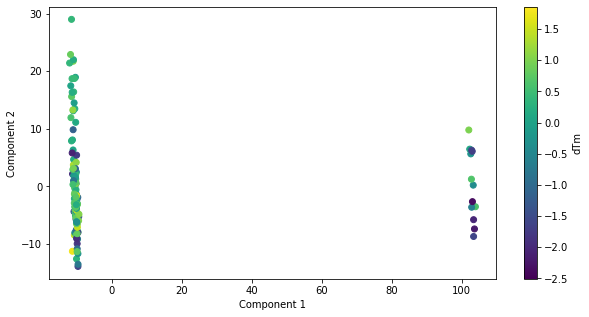

In [6]:
from protera_stability.utils.decomposition import dim_reduction

X = dim_reduction(train_set.X, train_set.y, n_components=32, plot_viz=True, prefix="dTm")
y = train_set.y

## Modelling

### Grid Search

In [13]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from protera_stability.utils.decomposition import dim_reduction
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=123)

reg = Ridge(alpha=1e2)
reg.fit(X_train, y_train)

print("Linear Regression R2", reg.score(X_valid, y_valid))

scoring = "r2"
score = r2_score
models = {
    "RandomForest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 100],
            "criterion": ["mse", "mae"]
        },
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1.0, 10.0],
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": [3],
            "gamma": ["scale"],
        },
    },
    "GB": {
        "model": GradientBoostingRegressor(),
        "params": {
            "learning_rate": [0.1, 0.03, 0.01],
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 16, 64]
        },
    },
}

Linear Regression R2 0.2067366948040268


In [14]:
from protera_stability.utils import perform_search

results = []
for name, model in models.items():
    search = perform_search(
        X_train,
        y_train,
        model["model"],
        model["params"],
        name,
        X_test=X_valid,
        y_test=y_valid,
        save_dir="./models-thermonuclease",
        n_jobs=8,
        verbose=False
    )

    results.append(search)

Fitting model RandomForest...
RandomForest best R2: 0.19263251557390032
Best params: {'criterion': 'mse', 'max_depth': 100, 'n_estimators': 100}
Test R2: 0.22258319212725675
Fitting model SVR...
SVR best R2: 0.31930367303098295
Best params: {'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Test R2: 0.11674120575866775
Fitting model GB...
GB best R2: 0.2717033379225925
Best params: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 200}
Test R2: 0.30321913428763947


```
============
Fitting model RandomForest...
RandomForest best R2: 0.19263251557390032
Best params: {'criterion': 'mse', 'max_depth': 100, 'n_estimators': 100}
Test R2: 0.22258319212725675
============
============
Fitting model SVR...
SVR best R2: 0.31930367303098295
Best params: {'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Test R2: 0.11674120575866775
============
============
Fitting model GB...
GB best R2: 0.2717033379225925
Best params: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 200}
Test R2: 0.30321913428763947
============
```

In [65]:
from joblib import load
ereg = load("./models/ensemble_tm.joblib")
tm_preds = ereg.predict(X_train)

In [62]:
import numpy as np
idx = 0

inverse_delta_op = lambda value, delta : value + np.sign(delta) * delta if np.sign(delta) == -1. else value - delta
thermonuclease_tm = inverse_delta_op(data.iloc[idx, 1], data.iloc[idx, 2])

In [72]:
train_set = ProteinStabilityDataset(proteins_path=data_path / "tm_fireprot.h5")
train_set.x_scaler.mean_

array([ 0.15262517, -0.03977118,  0.19068956, ..., -0.13178226,
       -0.23444186, -0.22619346])